In [23]:
# libraries
import numpy as np
import pandas as pd
import scipy 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree

import matplotlib.pyplot as plt

In [2]:
# read in data frames
election_38_df = pd.read_csv("data/merged/38_general_election.csv")
election_39_df = pd.read_csv("data/merged/39_general_election.csv")
election_40_df = pd.read_csv("data/merged/40_general_election.csv")
election_41_df = pd.read_csv("data/merged/41_general_election.csv")
election_42_df = pd.read_csv("data/merged/42_general_election.csv")
election_43_df = pd.read_csv("data/merged/43_general_election.csv")
election_44_df = pd.read_csv("data/merged/44_general_election.csv")

In [3]:
election_38_df

,Unnamed: 0,Political Entity,Recipient ID,Recipient,Recipient last name,Recipient first name,Political Party of Recipient,Electoral District,Electoral event,Fiscal/Election date,Contributor City,Contributor Province,Contributor Postal code,Contribution Received date,Monetary amount,cleaned_district_name_x,ED_CODE,Percentage of Votes Obtained /Pourcentage des votes obtenus,won_election
0,0,﻿Candidates,4716,"Béchard, Bruno-Marie",Béchard,Bruno-Marie,Liberal Party of Canada,Sherbrooke,38th general election,2004-06-28,Magog,QC,J1X 2C3,NaN,400.0,sherbrooke,24070.0,31.01,False
1,1,Candidates,4716,"Béchard, Bruno-Marie",Béchard,Bruno-Marie,Liberal Party of Canada,Sherbrooke,38th general election,2004-06-28,Sherbrooke,QC,J1L 2B6,NaN,500.0,sherbrooke,24070.0,31.01,False
2,2,Candidates,4716,"Béchard, Bruno-Marie",Béchard,Bruno-Marie,Liberal Party of Canada,Sherbrooke,38th general election,2004-06-28,Ascot,QC,J1K 3B4,NaN,500.0,sherbrooke,24070.0,31.01,False
3,3,Candidates,4716,"Béchard, Bruno-Marie",Béchard,Bruno-Marie,Liberal Party of Canada,Sherbrooke,38th general election,2004-06-28,Shebrooke,QC,J1H 4J9,NaN,2500.0,sherbrooke,24070.0,31.01,False
4,4,Candidates,4716,"Béchard, Bruno-Marie",Béchard,Bruno-Marie,Liberal Party of Canada,Sherbrooke,38th general election,2004-06-28,Katevale,QC,J0B 1W0,NaN,500.0,sherbrooke,24070.0,31.01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18501,18501,Candidates,5250,"Carter, Roger",Carter,Roger,Marxist-Leninist Party of Canada,Beaches--East York,38th general election,2004-06-28,NaN,NaN,NaN,NaN,0.0,beaches east york,35005.0,0.10,False
18502,18502,Candidates,5615,"Giguère, Philippe",Giguère,Philippe,New Democratic Party,Beauce,38th general election,2004-06-28,NaN,NaN,NaN,NaN,75.0,beauce,24005.0,3.05,False
18503,18503,Candidates,5141,"Morrison, Dean",Morrison,Dean,New Democratic Party,Langley,38th general election,2004-06-28,NaN,NaN,NaN,NaN,0.0,langley,59013.0,16.75,False
18504,18504,Candidates,4549,"Paradis, Denis",Paradis,Denis,Liberal Party of Canada,Brome--Missisquoi,38th general election,2004-06-28,NaN,NaN,NaN,NaN,0.0,brome missisquoi,24010.0,42.08,True


In [4]:
# create a "metadata" df to help out

# REFS:
# https://laws-lois.justice.gc.ca/eng/acts/e-2.01/section-405-20040101.html#wb-cont
# finding all the election limits to normalize the amounts
# https://laws-lois.justice.gc.ca/eng/acts/E-2.01/PITIndex.html



election_caps_dict = {
    "38": 5000,
    "39": 5000,
    "40": 1000,
    "41": 1000,
    "42": 1500,
    "43": 1500,
    "44": 1500
}

election_years_dict = {
    "38": 2004,
    "39": 2006,
    "40": 2008,
    "41": 2011,
    "42": 2015,
    "43": 2019,
    "44": 2021
}

metadata_elections_df = pd.DataFrame({
    "election": election_caps_dict.keys(),
    "contribution_cap": election_caps_dict.values(),
    "election_year": election_years_dict.values()
})

metadata_elections_df

,election,contribution_cap,election_year
0,38,5000,2004
1,39,5000,2006
2,40,1000,2008
3,41,1000,2011
4,42,1500,2015
5,43,1500,2019
6,44,1500,2021


In [5]:
# pull in inflation CPIs for adjusting to inflation

cpi_df = pd.read_csv('data/cpi.csv')
cpi_df = cpi_df[cpi_df['Products and product groups'] == 'All-items'][['REF_DATE', 'VALUE']]

cpi_df.head()

,REF_DATE,VALUE
0,2004,104.7
1,2005,107.0
2,2006,109.1
3,2007,111.5
4,2008,114.1


In [6]:
# rebase the CPI to 2004 = 100, since the data is using 2002 = 100
base_2004_cpi = cpi_df.loc[cpi_df['REF_DATE'] == 2004]['VALUE'][0]
cpi_df['VALUE'] = cpi_df['VALUE']/base_2004_cpi*100
cpi_df.head()

,REF_DATE,VALUE
0,2004,100.000000
1,2005,102.196753
2,2006,104.202483
3,2007,106.494747
4,2008,108.978032


In [7]:
metadata_elections_df = metadata_elections_df.copy().merge(cpi_df, left_on='election_year', right_on='REF_DATE')
metadata_elections_df

,election,contribution_cap,election_year,REF_DATE,VALUE
0,38,5000,2004,2004,100.000000
1,39,5000,2006,2006,104.202483
2,40,1000,2008,2008,108.978032
3,41,1000,2011,2011,114.517670
4,42,1500,2015,2015,120.916905
5,43,1500,2019,2019,129.894938
6,44,1500,2021,2021,135.243553


In [8]:
# setting up preprocessing for all the frames

columns_rename_map = {
    "Recipient ID": "recipient_id",
    "Political Party of Recipient": "political_party",
    "ED_CODE": "electoral_district", #use the code instead, need to remember to set this as categorical
    "Monetary amount": "monetary_amount",
    "Percentage of Votes Obtained /Pourcentage des votes obtenus": "percentage_vote"
}

def preprocess(df, election_number):
   
   # drop unneeded columns
   df = df.drop(columns=['Unnamed: 0', 'Political Entity', 'Electoral event', 'Fiscal/Election date', 
                        'Recipient last name', 'Recipient first name','Contributor City', 'Contributor Province', 
                        'Contributor Postal code', 'Contribution Received date', 'cleaned_district_name_x', 'Electoral District', 
                        'Recipient'], 
                errors='ignore')
    
   # remove any 0 monetary amounts - these are probably residuals from the non-monetary amounts, not relevant to our modelling here 
   df = df[df['Monetary amount'] != 0]

   # rename columns for consistency and ease 
   df = df.rename(columns=columns_rename_map, errors = 'ignore')

   # adjust for inflation, normalize to the contribution cap
   cpi = metadata_elections_df[metadata_elections_df['election'] == election_number]['VALUE'].iloc[0]
   cap = metadata_elections_df[metadata_elections_df['election'] == election_number]['contribution_cap'].iloc[0]

   df['monetary_amount'] = df['monetary_amount']/cap *cpi/100

   # add in election number
   df['election_number'] = election_number

   # groupby and agg
   df = df.groupby('recipient_id').agg(
      # aggregate functions 
      monetary_sum = pd.NamedAgg(column= 'monetary_amount', aggfunc="sum"), 
      num_donations = pd.NamedAgg(column= 'monetary_amount', aggfunc='count'),
      monetary_mean = pd.NamedAgg(column= "monetary_amount", aggfunc = 'mean'),
      monetary_std = pd.NamedAgg(column= 'monetary_amount', aggfunc= 'std'),
      monetary_min = pd.NamedAgg(column= 'monetary_amount', aggfunc= 'min'),
      monetary_max = pd.NamedAgg(column= 'monetary_amount', aggfunc= 'max'),

      # agg for the other columns
      political_party = pd.NamedAgg(column= 'political_party', aggfunc= 'first'),
      electoral_district = pd.NamedAgg(column = 'electoral_district', aggfunc= 'first'),
      #percentage_vote = pd.NamedAgg(column = 'percentage_vote', aggfunc = 'first'),
      election_number = pd.NamedAgg(column = 'election_number', aggfunc = 'first'),
      won_election = pd.NamedAgg(column = 'won_election', aggfunc= 'first')

   )
    
   return df

In [9]:
# check if recipient id is consistent across the years if needed

# process all the election dataframes, hold 44th back as the test dataset
election_38_processed_df = preprocess(election_38_df, "38")
election_39_processed_df = preprocess(election_39_df, "39")
election_40_processed_df = preprocess(election_40_df, "40")
election_41_processed_df = preprocess(election_41_df, "41")
election_42_processed_df = preprocess(election_42_df, "42")
election_43_processed_df = preprocess(election_43_df, "43")
election_44_processed_df = preprocess(election_44_df, "44")

test_df = election_44_processed_df

In [10]:
# stack the remaining frames together as the training set (debate if I want to do a train-validation split?? and whether I'd do it chronilogically or not)

train_df = pd.concat([election_38_processed_df, election_39_processed_df, election_40_processed_df, 
           election_41_processed_df, election_42_processed_df, election_43_processed_df], axis= 0)

train_df

,monetary_sum,num_donations,monetary_mean,monetary_std,monetary_min,monetary_max,political_party,electoral_district,election_number,won_election
recipient_id,,,,,,,,,,
4055,4.874148,35,0.139261,0.164178,0.050000,0.863880,Conservative Party of Canada,10003.0,38,False
4056,11.655000,80,0.145688,0.158331,0.050000,1.000000,Liberal Party of Canada,10003.0,38,True
4057,8.449500,62,0.136282,0.060450,0.046000,0.200000,Liberal Party of Canada,10004.0,38,True
4058,4.724000,21,0.224952,0.273790,0.050000,1.000000,Liberal Party of Canada,10005.0,38,True
4059,2.500000,22,0.113636,0.073455,0.050000,0.360000,Conservative Party of Canada,10005.0,38,False
...,...,...,...,...,...,...,...,...,...,...
42102,91.942503,117,0.785833,0.462895,0.107648,1.817663,Liberal Party of Canada,35117.0,43,False
42132,3.463865,7,0.494838,0.217725,0.259790,0.865966,Conservative Party of Canada,24053.0,43,False
42133,0.766380,4,0.191595,0.178816,0.030309,0.432983,Green Party of Canada,59005.0,43,False


In [11]:
# set categorical, train/validation split

train_df[['political_party', 'electoral_district', 'election_number']] = train_df[['political_party', 'electoral_district', 'election_number']].astype('category')
y_train_full = train_df['won_election']
X_train_full = train_df.drop(columns=['won_election'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [12]:
# pull in RF & XGBoost

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', enable_categorical = True)
bst.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [13]:
pred = bst.predict(X_valid)
pred

array([1, 0, 0, ..., 0, 1, 0], shape=(1084,))

In [14]:
y_true = y_valid.astype('int').values
accuracy_score(y_true, pred)

0.7702952029520295

In [15]:
# implement 5-fold cv to check for robustness

bst_fold = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', enable_categorical = True)
kf = KFold(n_splits=5, shuffle=True, random_state=123)
accuracies = []


for train_idx, val_idx in kf.split(X_train_full):
    X_train, X_valid = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_valid = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    bst.fit(X_train, y_train)
    pred = bst.predict(X_valid)
    y_true = y_valid.astype('int').values
    acc = accuracy_score(y_true, pred)
    accuracies.append(acc)

accuracies

[0.7534562211981567,
 0.790080738177624,
 0.7577854671280276,
 0.754325259515571,
 0.7358708189158016]

In [16]:
# extract tree 

booster = bst.get_booster()

# Get tree dump as DataFrame
tree_df = booster.trees_to_dataframe()

tree_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,political_party,NaN,0-2,0-1,0-1,512.270386,619.266052,"[1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, ..."
1,0,1,0-1,monetary_sum,6.588600,0-3,0-4,0-4,124.676956,316.148804,None
2,0,2,0-2,monetary_max,5.562239,0-5,0-6,0-6,92.174896,303.117249,None
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.267173,160.305832,NaN
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,1.523258,155.842972,NaN
5,0,5,0-5,Leaf,NaN,NaN,NaN,NaN,-1.076407,282.588104,NaN
6,0,6,0-6,Leaf,NaN,NaN,NaN,NaN,1.079808,20.529142,NaN
7,1,0,1-0,electoral_district,NaN,1-2,1-1,1-1,59.641830,557.913086,"[13, 14, 16, 24, 26, 28, 30, 35, 37, 39, 41, 4..."
8,1,1,1-1,political_party,NaN,1-4,1-3,1-3,58.067463,427.449432,"[1, 2, 6, 7, 9, 11]"
9,1,2,1-2,political_party,NaN,1-6,1-5,1-5,21.743996,130.463638,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


<Axes: >

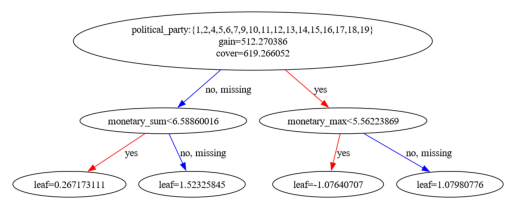

In [17]:
# matplotlib to plot the tree
plot_tree(bst)


In [22]:
tree_metadata_df = pd.DataFrame({"feature": X_train_full.columns, "importance": bst.feature_importances_})
#bst.feature_importances_
tree_metadata_df

,feature,importance
0,monetary_sum,0.263112
1,num_donations,0.000000
2,monetary_mean,0.000000
3,monetary_std,0.000000
4,monetary_min,0.000000
5,monetary_max,0.194522
6,political_party,0.416501
7,electoral_district,0.125865
8,election_number,0.000000


In [20]:
# political parties encoding:
encoding_df = pd.DataFrame({
    'Code': range(len(X_train_full['political_party'].cat.categories)),
    'Category': X_train_full['political_party'].cat.categories
})
encoding_df

,Code,Category
0,0,Bloc Québécois
1,1,Canadian Action Party
2,2,Christian Heritage Party of Canada
3,3,Conservative Party of Canada
4,4,First Peoples National Party of Canada
5,5,Forces et Démocratie
6,6,Green Party of Canada
7,7,Independent
8,8,Liberal Party of Canada
9,9,Libertarian Party of Canada


In [25]:
# grid search CV for hyperparameter tuning + cv at the same time

bst_cv = XGBClassifier(objective='binary:logistic', enable_categorical = True)

clf = GridSearchCV(
    bst_cv,
    {"n_estimators": [1,2,3], "max_depth": [2,4,6], "learning_rate": [0.1, 1, 5]},
    verbose = 1
)

clf.fit(X_train_full, y_train_full)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.7785985361886689
{'learning_rate': 1, 'max_depth': 4, 'n_estimators': 3}
